# Cashew Disease Classification Using Convolutional Neural Networks (CNN)

In this project, we will implement a machine learning model using Convolutional Neural Networks (CNN) to classify diseases in cashew trees based on images of their leaves. The goal is to automate the process of detecting diseases, which can help farmers manage crop health and improve productivity.

## Objectives:
- Preprocess and prepare a dataset of images containing cashew leaves affected by various diseases.
- Implement a CNN model to learn patterns in the images and classify them into different categories.
- Evaluate the model's performance using metrics such as accuracy, precision, recall, and F1-score.

## Key Steps:
1. **Data Collection**: We will gather images of healthy and diseased cashew leaves. These images will serve as our dataset.
2. **Data Preprocessing**: Resize, normalize, and augment the images to prepare them for training.
3. **Model Building**: Implement using Keras/TensorFlow to classify the images.
4. **Training**: Train the CNN model on the preprocessed dataset.
5. **Evaluation**: Evaluate the model's performance using test data and metrics.
6. **Prediction**: Test the model with new, unseen images to predict disease classification.

By the end of this project, we aim to develop a robust model that can assist in early disease detection for cashew trees, ultimately aiding in better crop management and yield.

Let's get started by loading the dataset and performing some initial exploration!


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
!pip install gdown

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay, accuracy_score
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output

In [8]:
tf.__version__

'2.16.1'

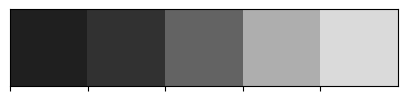

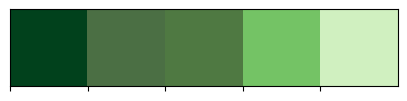

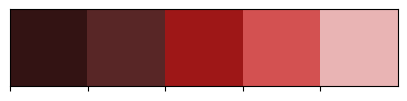

In [9]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [10]:
labels = ['anthracnose','gumosis','healthy','leaf miner',"red rust"]
CLASS_NAMES = labels

In [11]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/kaggle/input/cashew-image-dataset/Cashew','train_set',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/cashew-image-dataset/Cashew','test_set',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 1815/1815 [00:15<00:00, 116.19it/s]


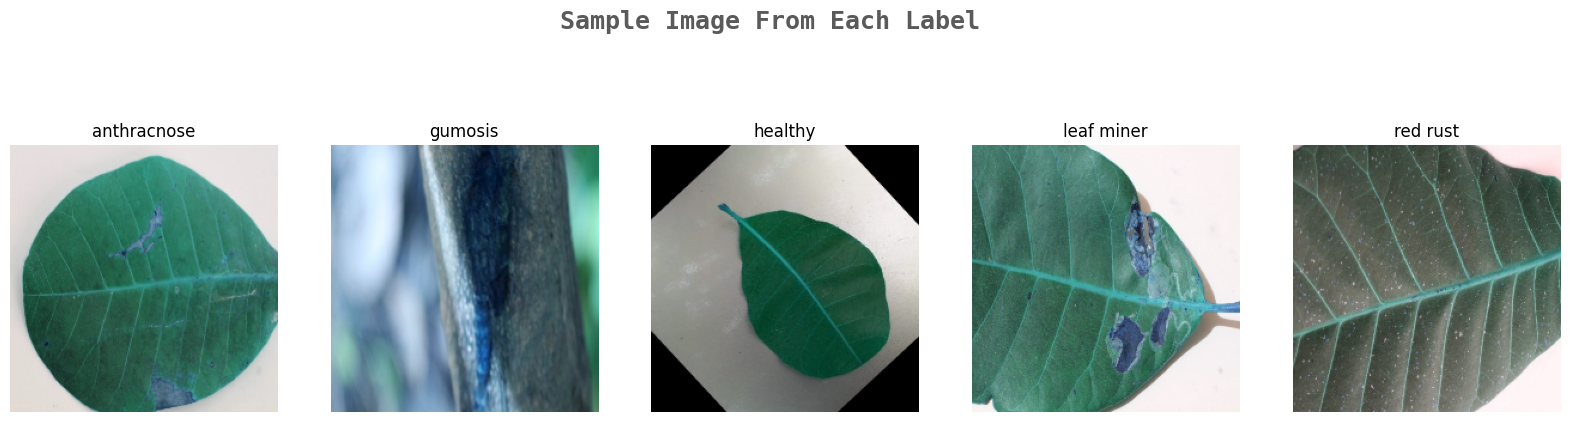

In [12]:
k=0
fig, ax = plt.subplots(1,5,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [13]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [14]:
X_train.shape

(25811, 224, 224, 3)

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

In [16]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [17]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(5,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [19]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 4,013,953 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [20]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [22]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("cashew-effnet.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [23]:
history = model.fit(X_train,y_train,validation_split=0.2, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12


I0000 00:00:1732128650.636294     168 service.cc:145] XLA service 0x7b90c000be60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732128650.636339     168 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732128650.636345     168 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732128702.249584     168 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8550 - loss: 0.4191

I0000 00:00:1732128813.203321     169 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 160 bytes spill stores, 160 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 16 bytes spill stores, 16 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.92833, saving model to cashew-effnet.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 209s 242ms/step - accuracy: 0.8551 - loss: 0.4188 - val_accuracy: 0.9283 - val_loss: 0.2294 - learning_rate: 0.0010
Epoch 2/12
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9497 - loss: 0.1596
Epoch 2: val_accuracy improved from 0.92833 to 0.94891, saving model to cashew-effnet.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 75s 145ms/step - accuracy: 0.9497 - loss: 0.1596 - val_accuracy: 0.9489 - val_loss: 0.1772 - learning_rate: 0.0010
Epoch 3/12
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9637 - loss: 0.1219
Epoch 3: val_accuracy did not improve from 0.94891
517/517 ━━━━━━━━━━━━━━━━━━━━ 74s 144ms/step - accuracy: 0.9637 - loss: 0.1218 - val_accuracy: 0.9465 - val_loss: 0.1681 - learning_rate: 0.0010
Epoch 4/12
516/517 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9643 - loss: 0.1115
Epoch 4: val_accuracy improved from 0.94891 to 0.96634, saving model t

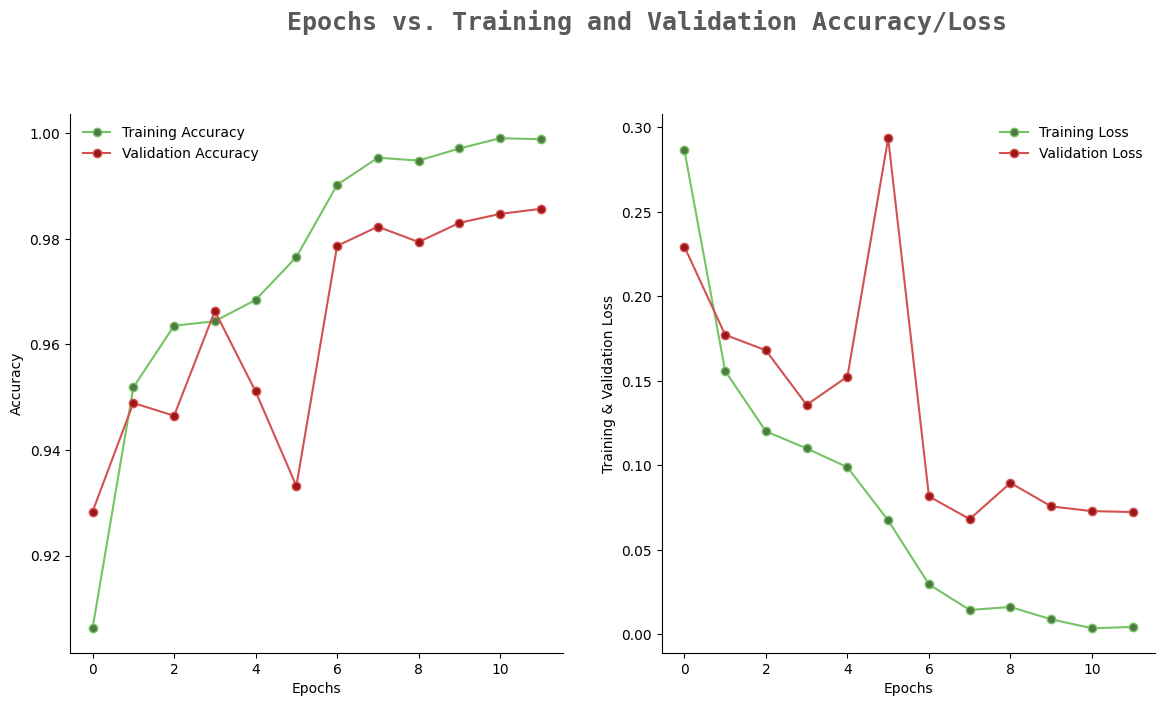

In [24]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [25]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

162/162 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step


In [26]:
cr = classification_report(y_test_new,pred)
cmetric = confusion_matrix(y_test_new,pred)

In [27]:
raw_data = cr.split("\n")
precision = []
recall = []
f1_score = []
for line in raw_data[2:-5]:
    line = line.split()
    precision.append(float(line[1]))
    recall.append(float(line[2]))
    f1_score.append(float(line[3]))

In [36]:
cr = classification_report(y_true, y_test_classes)
cmetric = confusion_matrix(y_true, y_test_classes)
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       995
           1       1.00      1.00      1.00       405
           2       0.98      0.99      0.99      1448
           3       0.97      0.98      0.98      1000
           4       1.00      1.00      1.00      1315

    accuracy                           0.98      5163
   macro avg       0.98      0.98      0.98      5163
weighted avg       0.98      0.98      0.98      5163



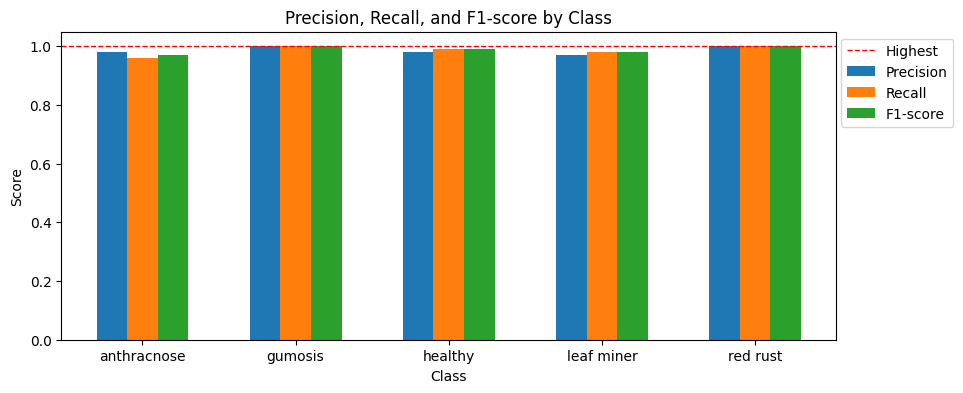

In [28]:
# Plot precision, recall, and F1-score
plt.figure(figsize=(10, 4))
x = range(len(labels))
width = 0.2

plt.bar(x, precision, width, label='Precision')
plt.bar([i + width for i in x], recall, width, label='Recall')
plt.bar([i + 2 * width for i in x], f1_score, width, label='F1-score')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score by Class')
plt.xticks([i + width for i in x], labels)
plt.axhline(y=1, color='red', linestyle='--', linewidth=1, label='Highest')

plt.legend(loc='upper right', bbox_to_anchor=(1.16, 1), shadow=False, ncol=1)
plt.show()

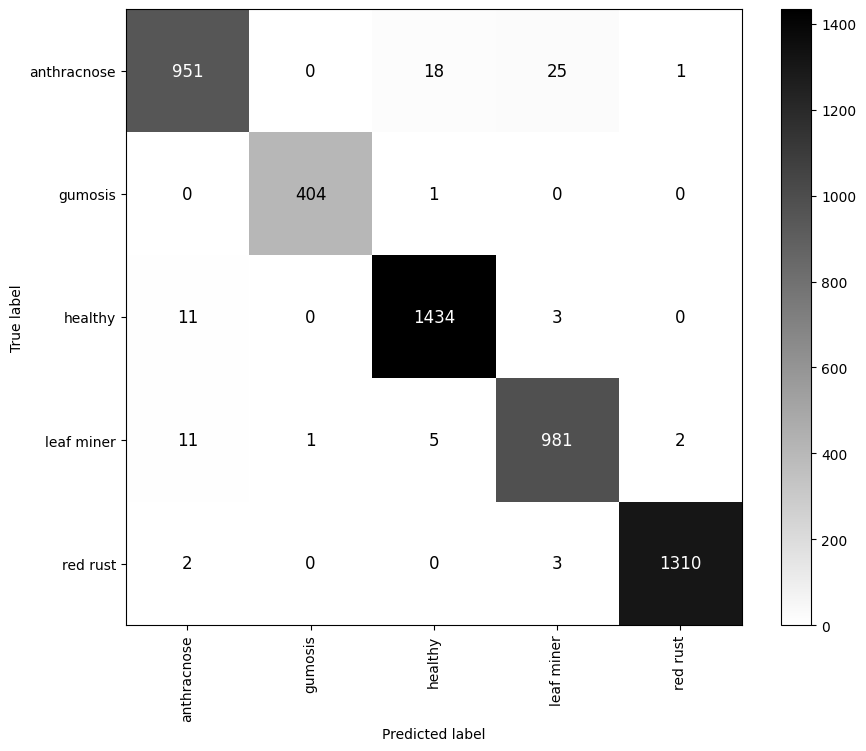

In [29]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

CLASS_NAMES = labels
# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cmetric, display_labels=CLASS_NAMES)
disp.plot(ax=ax, cmap='binary')

# Customize x-axis and y-axis ticks with class names
ax.set_xticks(range(len(CLASS_NAMES)))  # Set x-ticks to match the number of classes
ax.set_xticklabels(CLASS_NAMES, rotation=90)  # Set x-tick labels as class names with 90-degree rotation

ax.set_yticks(range(len(CLASS_NAMES)))  # Set y-ticks to match the number of classes
ax.set_yticklabels(CLASS_NAMES)  # Set y-tick labels as class names

# Set font size for the text in the plot
for text in ax.texts:
    text.set_fontsize(12)

# Remove axis labels
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.grid(False)
# Show plot
plt.show()

In [30]:
test_predictions = model.predict(X_test)

162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step


In [31]:
y_val_indexes = np.array([val.argmax() for val in tqdm(y_test)])
y_val_indexes[:5]

100%|██████████| 5163/5163 [00:00<00:00, 794103.10it/s]


array([0, 1, 4, 4, 3])

In [32]:
y_test_classes = np.argmax(test_predictions, axis=1)
y_test_classes[0:5]

array([0, 1, 4, 4, 0])

In [33]:
y_test_classes.shape, y_val_indexes.shape

((5163,), (5163,))

In [34]:
y_true = y_val_indexes
accuracy = accuracy_score(y_true, y_test_classes)
accuracy

0.9839240751501065

In [37]:
# First prediction
index = 40
print(test_predictions[index])
print(f"Max value (probability of prediction): {np.max(test_predictions[index])}")
print(f"Sum: {np.sum(test_predictions[index])}")
print(f"Max index: {np.argmax(test_predictions[index])}")
print(f"Predicted label: {CLASS_NAMES[np.argmax(test_predictions[index])]}")

[1.02991204e-13 5.02509953e-14 4.38398498e-16 3.16027690e-11
 1.00000000e+00]
Max value (probability of prediction): 1.0
Sum: 1.0
Max index: 4
Predicted label: red rust


In [38]:
CLASS_NAMES[4]

'red rust'

In [39]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return CLASS_NAMES[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(test_predictions[81])
pred_label

'gumosis'

In [40]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], CLASS_NAMES[labels[n]], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image.astype("uint8"))
  plt.xticks([])
  plt.yticks([])
    
  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

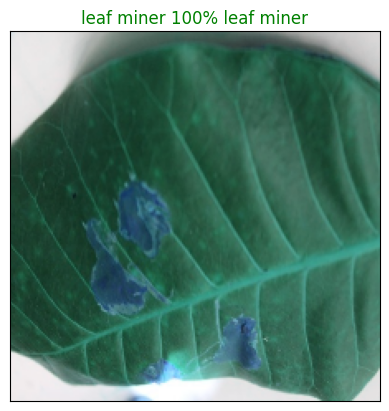

In [41]:
plot_pred(prediction_probabilities=test_predictions,
          labels=y_val_indexes,
          images=X_test,
          n=2400)
plt.show()

In [42]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)
  # Find the top  prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[::-1]

#   print(top_10_pred_indexes)
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = top_10_pred_indexes
  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

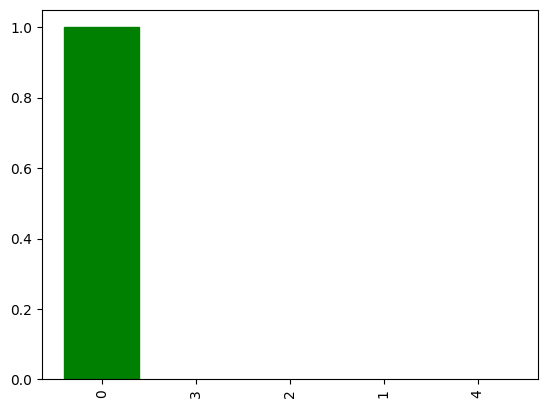

In [43]:
plot_pred_conf(prediction_probabilities=test_predictions,
               labels=y_val_indexes,
               n=8)

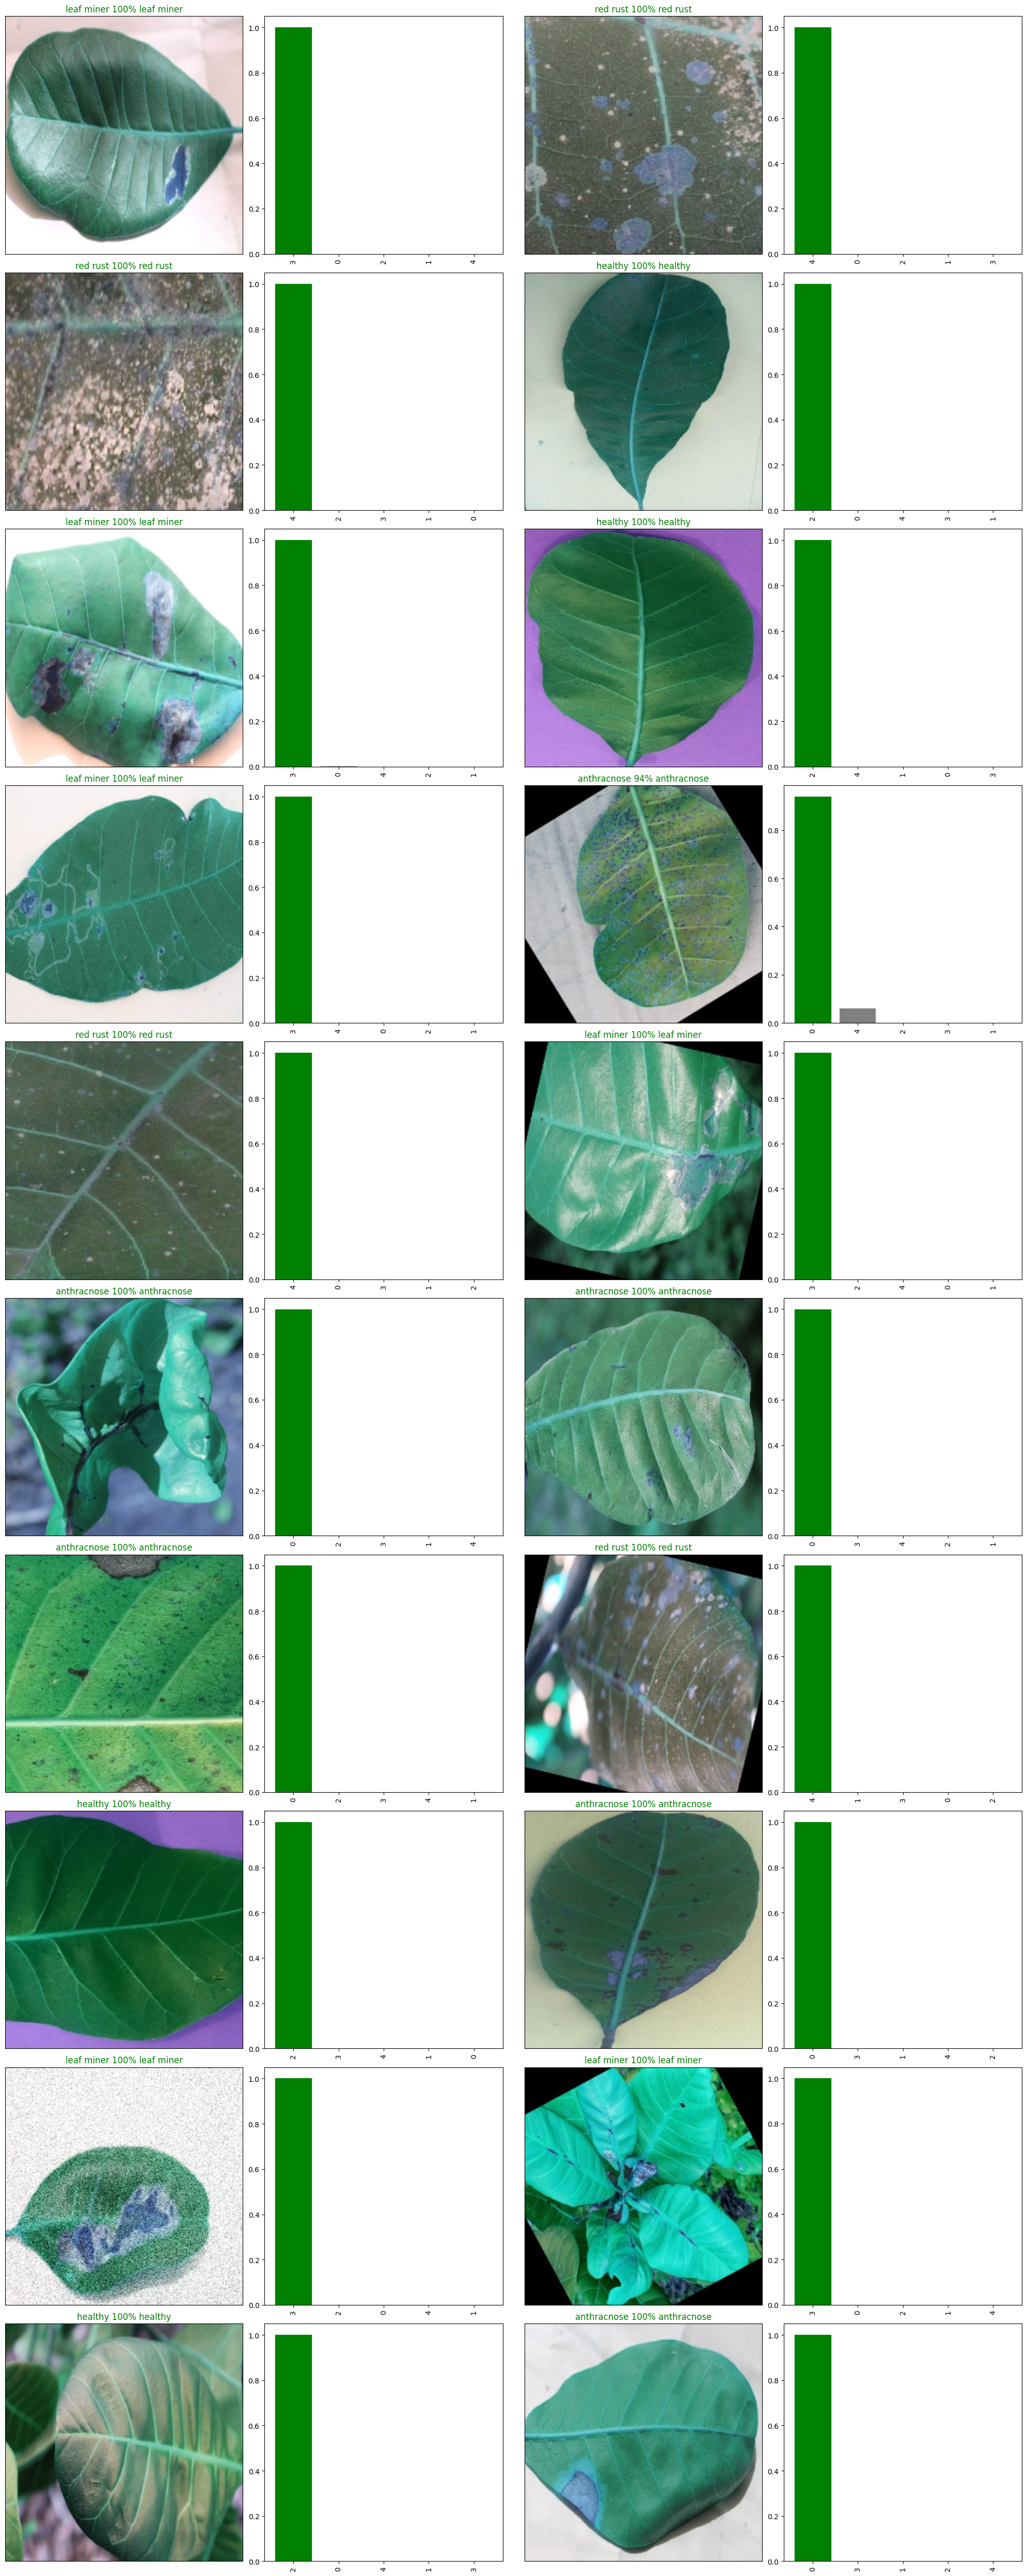

In [44]:
i_multiplier = 20
num_rows = 10
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=test_predictions,
            labels=y_val_indexes,
            images=X_test,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=test_predictions,
                 labels=y_val_indexes,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()